<center> <h1> OTGAN </h1> </center>


Based on :

[1] Tim Salimans, Han Zhang, Alec Radford, and Dimitris Metaxas. **Improving GANs using optimal
transport.** In ICLR, 2018.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import seaborn as sns 
sns.set(palette='gray')

import os
import argparse
from datetime import datetime

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm
import pickle



In [0]:
# path = "C:/Users/Philo/Documents/3A -- ENSAE/Optimal transport/OTGAN"
# os.chdir(path)

### Model parameters and hyperparameters

In [0]:
args={}
kwargs={}
args['batch_size']=128
args['val_batch_size']=128
args['n_epochs']=2

# Use the same value as author's for CIFAR for Adam LR and beta values :
args['lr']=3e-4
args['beta1']= 0.5
args['beta2']= 0.999


args['seed']=1 #random seed
args['cuda']=True if torch.cuda.is_available() else False
device = "cuda" if args['cuda']==True else "cpu"


args["n_gen"] = 3 # number of generator updates per critic update (as in CIFAR's example)

In [73]:
print ('parameters \n')
for key in args.keys():
  print(key, args[key])

parameters 

batch_size 128
val_batch_size 128
n_epochs 2
lr 0.0003
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 3


In [74]:
# Random seeds
np.random.seed(args['seed'])
torch.random.manual_seed(args['seed']) #noGPU
# torch.cuda.seed(args['seed']) #single GPU
# torch.cuda.manual_seed_all(args['seed']) #several GPUs


In [75]:
#if using colab 
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

##  MNIST dataset

- Mnist (train set ) : 60000  gray images representing digits of size 28 x 28
Usps  (train set ) 
- We normalize them by substracting the mean and the std

In [0]:
path_data = '/content/drive/My Drive/optimal_transport/data'  #where to download data
path = '/content/drive/My Drive/optimal_transport/' #where to save pickle with trained model
#path_data = '../data/MNIST'

# Define dataset transformation
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)) #use MNIST mean and std #A changer ?
                              ])

# ## Preliminary step : download dataset
trainset = datasets.MNIST(root= path_data, download=True, train=True, transform=transform)
# valset = datasets.MNIST('../data/MNIST', download=True, train=False, transform=transform)

trainset = torchvision.datasets.MNIST(root=path_data, train=True, transform=transform)
# valset = torchvision.datasets.MNIST('../data/MNIST', train=False, transform=transform)


In [77]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/optimal_transport/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Size of the input image :  torch.Size([1, 28, 28])


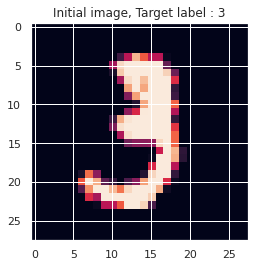

In [78]:
index = 10
print("Size of the input image : ",trainset[index][0].size())
plt.imshow(trainset[index][0].view(trainset[index][0].size()[1],trainset[index][0].size()[2]))
plt.title("Initial image, Target label : "+str(trainset[index][1]))
plt.show()

### Train and validation loaders

In [0]:
train_loader = DataLoader(trainset, args['batch_size'], shuffle=True, **kwargs)
# val_loader = DataLoader(valset, args['val_batch_size'], shuffle=True, **kwargs)

### pad the images or resize them  to obtain 32x32 images

- We need to get images of this size to use the same architecture as in the article 

In [0]:
from torchvision.datasets import VisionDataset
from torchvision import transforms

In [0]:
# check_black = [tup[0][0,0,0].item() for tup in trainset]+[tup[0][0,0,0].item() for tup in valset]
# assert len(check_black) == len(trainset) + len(valset)
# padding_val = list(set(check_black))[0]
padding_val = trainset[0][0][0][0][0]
resizing_val = 32

In [82]:
padding_val.item()

-0.4242129623889923

In [0]:
class MNISTPad(VisionDataset):
    '''Class of dataset MNIST padded

    Attributes
    dataset : initial data set 
    rescaling_method : string : string " either padding or resizing
    padding : integer :value of padding if rescaling_method = padding
    resize_shape: integer : value of resized image  if rescaling_method = 'resizing
    '''

    def __init__(self, dataset, rescaling_method = 'padding', padding=2, 
                 resize_shape=None):
        self.images = [tup[0] for tup in dataset]
        self.target = [tup[1] for tup in dataset]
        self.rescaling_method = rescaling_method  
        self.padding = padding 
        self.resize_shape = resize_shape 
        self.root = dataset 
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
        if self.rescaling_method == "padding":
            img = F.pad(img, 
                        # utiliser l'étoile ? 
                        pad=(self.padding, self.padding, self.padding, self.padding),
                        mode='constant', value=padding_val)
        
        if self.rescaling_method  == "resizing":
            #TODO : add the resizing option instead of padding 
            self.transform = Compose([
#                         transforms.ToPILImage(),
                        transforms.Resize(self.resize_shape),
                        transforms.ToTensor(),
                        ])
            img = self.transform(img)
            
        return img, target

In [84]:
#trainset with padding images 
trainset_pad = MNISTPad(trainset, "padding", 2)
trainset_pad

Dataset MNISTPad
    Number of datapoints: 60000
    Root location: Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/optimal_transport/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [0]:
# trainset_resized= MNISTPad(trainset, rescaling_method='resizing', resize_shape=32)

#### using the transforms


In [0]:
#padding_transform = transforms.Compose([
                  #transforms.Pad(padding=2, fill=padding_val.item()), 
                    #transforms.Normalize((0.1307,), (0.3081,)), #cette ligne fait buguer le loader
                    #transforms.ToTensor()])
#trainset_pad= datasets.MNIST(root = path_data, download=True, train=True, transform=padding_transform )

In [0]:
#trainset_pad[0]

In [0]:
resized_transform = transforms.Compose([
                    transforms.Resize(32), 
                    #transforms.Normalize((0.1307,), (0.3081,)), #cette ligne fait buguer le loader
                    transforms.ToTensor()])
trainset_resized = datasets.MNIST(root = path_data, download=True, train=True, transform=resized_transform )

In [0]:
# valset_pad = MNISTPad(valset, "padding", 2)
# valset_pad

###New Train and validation loaders

In [0]:
train_pad_loader = DataLoader(trainset_pad, args['batch_size'], shuffle=True, **kwargs)
train_resized_loader = DataLoader(trainset_resized, args['batch_size'], shuffle=True, **kwargs)

In [91]:
dataiter_mnist_resized = iter(train_resized_loader)
dataiter_mnist_pad = iter(train_pad_loader)
images_mnist_resized, _ = dataiter_mnist_resized.next()
images_mnist_pad, _ = dataiter_mnist_pad.next()
print('mnist shape resized ', images_mnist_resized.shape) 
print('mnist shape padded ', images_mnist_pad.shape) 


mnist shape resized  torch.Size([128, 1, 32, 32])
mnist shape padded  torch.Size([128, 1, 32, 32])


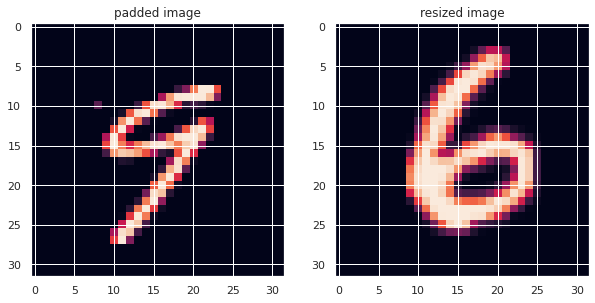

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(images_mnist_pad[0].numpy().squeeze())
ax[0].set_title('padded image')
ax[1].imshow(images_mnist_resized[0].numpy().squeeze())
ax[1].set_title('resized image')
plt.show()

## Create gaussian mixture 'images'

In [0]:
def simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes = 8):
    '''Simulate gaussian mixture with nb_modes modes arranges around the unit circle
    Inputs :
    cov_mixt_ratio : the ratio by which the identity is divided when defining the covariance matrix
    size_mixt : the size of the vector for EACH gaussian. #number of points generated for each gaussian
    nb_modes : the number of gaussiam  mixtures
    Outputs : 
    a numpy array of dimension (size_mixt*nb_modes , 2)
    '''
    val = np.arange(0,2*np.pi,np.pi/(nb_modes/2)) 
    x_val = np.cos(val)
    y_val = np.sin(val)
    mixture = []
    for i in range(len(val)):
        mixture.append(np.random.multivariate_normal(mean = [x_val[i],y_val[i]], cov = np.identity(2)/cov_mixt_ratio, size = size_mixt))

    mixture_vect = mixture[0]
    for i in range(1,len(val)):
        mixture_vect = np.concatenate([mixture_vect,mixture[i]])
    return mixture_vect

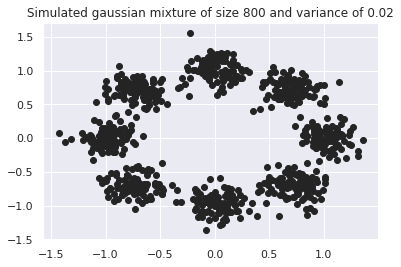

In [94]:
nb_modes = 8
size_mixt = 100
cov_mixt_ratio = 50 #aparent modes but not too separeted
mixture_vect = simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes)
plt.scatter(mixture_vect[:,0],mixture_vect[:,1])
plt.title("Simulated gaussian mixture of size "+str(nb_modes*size_mixt)+" and variance of "+str(1/cov_mixt_ratio))
plt.show()

The simulated gaussian mixtures need to be converted to an image. 

In [0]:
def array_to_img(array, img_size, return_normalized = False):
    """Function
    array : an array of dimension Kx2
    img_size : the dimension of the (squared) image obtained
    return_normalized : also return the normalized array (for comparison)
    """
    mixture_norm = array+np.abs(np.min(array))
    mixture_norm = mixture_norm/(np.max(mixture_norm)-np.min(mixture_norm))
    round_array = np.round(mixture_norm*(img_size-1))
    gauss_img = np.zeros((img_size,img_size))
    for i in range(round_array.shape[0]):
        gauss_img[int(round_array[i,:][0]),int(round_array[i,:][1])] = 255
    if return_normalized == False :
        return gauss_img
    else :
        return gauss_img, mixture_norm

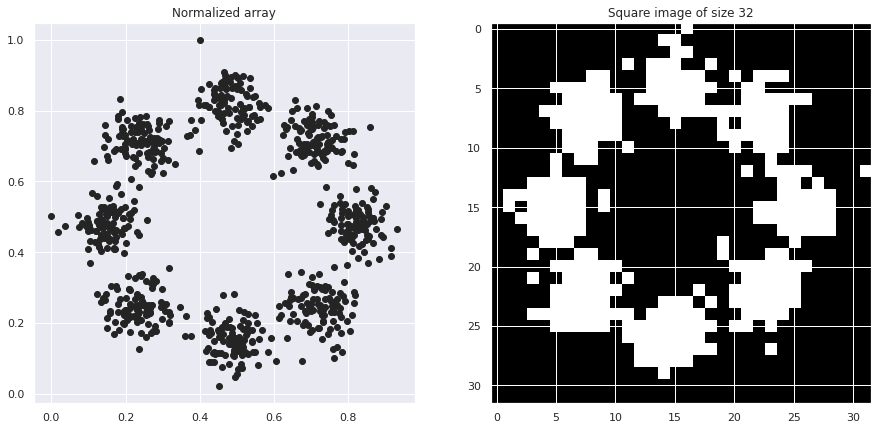

In [96]:
img_size = 32
gauss_img, mixture_norm = array_to_img(mixture_vect, img_size, return_normalized = True)

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(mixture_norm[:,0],mixture_norm[:,1])
ax[0].set_title('Normalized array')
ax[1].imshow(gauss_img, cmap=plt.cm.gray)
ax[1].set_title('Square image of size '+str(img_size))
plt.show()

In [0]:
class GaussianMixtureDB(VisionDataset):
    '''Class with gaussian mixture data'''
    def __init__(self, dataset):
        self.images = dataset
        self.target = [0 for i in range(len(dataset))]
        self.root = "add/pickle/location"
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
            
        return img, target

In [0]:
size_GaussianMixtureDB = 20*args["batch_size"]
GaussianMixture_array = [simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes) for i in range(size_GaussianMixtureDB)]
GaussianMixture_imgs = [array_to_img(array, img_size, return_normalized = False) for array in GaussianMixture_array]
GaussianMixture_trainset = GaussianMixtureDB(GaussianMixture_imgs)
GaussianMixture_loader = DataLoader(GaussianMixture_trainset, args['batch_size'], shuffle=True, **kwargs)

In [99]:
GaussianMixture_trainset

Dataset GaussianMixtureDB
    Number of datapoints: 2560
    Root location: add/pickle/location

In [0]:
try :
    del GaussianMixture_array
#     del GaussianMixture_imgs
except :
    print("deleted")

# Build the GAN 

## Generator

### Define Generator's architecture 
See Table 3 of [1]

As showed in the article for the CIFAR dataset : we use a $Uniform([-1,1])$ to generate noise

**Note** : We consider 3 dimensions for the 32x32 image, but we could have considered only one (greyscale image)

In [0]:
class _UpBlock_Generator(nn.Module):
    '''
    Class used in the Generator architecture
    Defines the 2xNN upsample, convolution and GLU for a given input size in_channels
    Input size : [bs, in_channels, n, n]
    Output size : [bs, in_channels/2, 2*n, 2*n]
    '''
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 2*in_channels, out_channels = 2*in_channels, 
                              kernel_size = 5, padding=2, stride = 1)
        #in_channels = 2*initial dimension because NN upsampler multiplies by 2 height and width

    def forward(self, x: Tensor) -> Tensor:
        x =  F.interpolate(x, scale_factor=(2,2), mode = "nearest") #multiplies by 2
        x = self.conv(x)
        x = F.glu(x,dim=1) #GLU activation devides by 2 the number of channels
        return x

In [0]:
class Generator32x32(nn.Module):
    '''Class defining the Generator with the same architecture as used by Salimans. et al. for the CIFAR dataset
    Input : 
    input_dim : dimension of the noise z
    out_channels : number of colour channel (1 by default for greyscale images)
    
    '''
    def __init__(self, input_dim: int=100, out_channels = 1):
        super(Generator32x32, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=32768)
        #need to define out features = 2*16384 because glu devides by 2 the number of units
        self.up1 = _UpBlock_Generator(512) ###Pas bizarre de mettre un padding de 2?? 
        self.up2 = _UpBlock_Generator(256)
        self.up3 = _UpBlock_Generator(128)
        self.last_conv = nn.Conv2d(in_channels = 128, out_channels = out_channels, kernel_size = 5, padding=2, stride = 1)
    
    def generate_noise(self, bs, k=100):
        ''' Generate noise with dimension [bs, k] following a Uniform([-1,1])'''
        z = (torch.rand([bs, k], requires_grad = True)*2)-1
        return z
    
    def forward(self, x: Tensor):
        bs = x.size()[0]
        ## Linear layer and reshape
        x1 = self.linear(x) 
        x1_a = F.glu(x1) 
        assert x1_a.size() == (bs, 16384)
        x2 = x1_a.reshape(bs,1024,4,4) # size [bs, 1024, 4, 4] 
        assert x2.size() == (bs, 1024, 4, 4)
        ## Up blocks : upsample, convolution and GLU
        x3 =  self.up1(x2) # size [bs, 512, 8, 8]
        assert x3.size() == (bs, 512, 8, 8)
        x4 =  self.up2(x3) # size [bs, 256, 16, 16]
        assert x4.size() == (bs, 256, 16, 16)
        x5 =  self.up3(x4) # size [bs, 128, 32, 32]
        assert x5.size() == (bs, 128, 32, 32)
        
        ## last convolution and activation
        x6 = self.last_conv(x5) # size [bs, 1, 32, 32]
        x7 = torch.tanh(x6) 
        out = x7 # size [bs, 1, 32, 32]
        assert out.size() == (bs, 1, 32, 32)
        return out 

#### New architecure

<a href = 'https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60'> architecture found here </a>

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size=100, hidden_dim=32, output_size=784):
      super(Generator, self).__init__()
      
      # 1
      self.fc1 = nn.Linear(input_size, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
      self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
      
      # 2
      self.fc4 = nn.Linear(hidden_dim*4, output_size)
    
      # 3
      self.dropout = nn.Dropout(0.3)

    def generate_noise(self, bs, k=100):
        ''' Generate noise with dimension [bs, k] following a Uniform([-1,1])'''
        z = (torch.rand([bs, k], requires_grad = True)*2)-1
        return z

    def forward(self, x):
      # 4
      x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.fc2(x), 0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.fc3(x), 0.2)
      x = self.dropout(x)
      # 5
      out = F.tanh(self.fc4(x))
      return out

In [104]:
generator = Generator()
z = generator.generate_noise(bs = 128, k = 100)
out = generator(z)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Generate noise 

In [0]:
# Initialize random seed
torch.random.manual_seed(args['seed'])

# Define generator model
generate = Generator32x32()

noize shape torch.Size([1, 100])


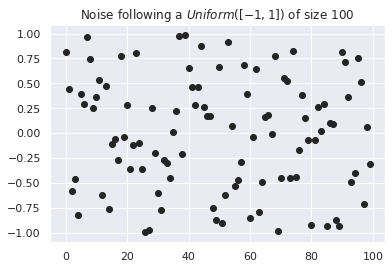

In [106]:
# Generate noise of given batch size
k=100
# z = generate.generate_noise(bs = args["batch_size"], k = k)
z = generate.generate_noise(bs = 1, k = k)
print('noize shape', z.size())


# Scatter one example of noise
plt.scatter(range(k),z[0].detach())
plt.title("Noise following a $Uniform([-1,1])$ of size "+str(k))
plt.show()

In [107]:
# Test the output of the generator network
z = generate.generate_noise(bs = 10, k = k)
print(z.size())
generator_output = generate(z)
print("Output size : ",generator_output.size())
#print(generator_output)

torch.Size([10, 100])
Output size :  torch.Size([10, 1, 32, 32])


## Critic / Discriminator

### Define critic architecture
See Table 4 of [1]

- Concatenated ReLU has two outputs, one ReLU and one negative ReLU, concatenated together. In other words, for an input vector x, CRelu(x) =$[(x)_+ ; (-x)_+] = [Relu(x);Relu(-x)]$. Because it has two outputs, CReLU doubles the output dimension.



In [0]:
class _DownBlock_Critic(nn.Module):
    '''
    Class used in the Critic architecture
    Defines the convolution and CReLU 
    Input size : [bs, in_channels, n, n]
    Output size : [bs, in_channels*2, n/2, n/2]
    Inputs : 
    in_channels : int
    '''
    def __init__(self, in_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, 
                              kernel_size = 5, padding=2, stride = 2)

    def forward(self, x: Tensor) -> Tensor:
        x =  self.conv(x) 
        x = torch.cat((self.relu(x),self.relu(-x)),dim=1) #doubles the outpout dimension
        return x

In [0]:
class Critic32x32(nn.Module):
    '''Class defining the critic with the same architecture as used by Salimans. et al. for the CIFAR dataset
    Input : 
    nb_channels : number of channels in the image (in particular, 1 or 3 ?)
    
    '''
    def __init__(self, nb_channels: int=1):
        super(Critic32x32, self).__init__()
        self.relu=nn.ReLU()
        self.init_conv = nn.Conv2d(in_channels = nb_channels, 
        out_channels = 128, kernel_size = 5, padding = 2, stride = 1) #? 
        self.down1 = _DownBlock_Critic(256)
        self.down2 = _DownBlock_Critic(512)
        self.down3 = _DownBlock_Critic(1024)
        
        
    def forward(self, x: Tensor):
        bs = x.size()[0]
        ## Initial convolution and CReLU
        x1 = self.init_conv(x) # size [bs, 128, 32, 32]
        assert x1.size() == (bs, 128, 32, 32)
        x2 = torch.cat((self.relu(x1),self.relu(-x1)),dim=1) #size [bs, 256, 32, 32]
        assert x2.size() == (bs, 256, 32, 32)
        ## Apply down block three times
        x3 = self.down1(x2) # size [bs, 512, 16, 16]
        assert x3.size() == (bs,  512, 16, 16)
        x4 = self.down2(x3) # size [bs, 1024, 8, 8]
        assert x4.size() == (bs, 1024, 8, 8)
        x5 = self.down3(x4) # size [bs, 2048, 4, 4]
        assert x5.size() == (bs, 2048, 4, 4)
        ## Reshaping and l2 normalization
        x5_reshape = x5.reshape(bs, 32768) # size [bs, 32768]
        assert x5_reshape.size() == (bs, 32768)
#         x5_norm = (torch.norm(x5_reshape, p=2, dim=1)+1e-10).view(bs,1) # size [1, bs]
        x5_norm = (torch.norm(x5_reshape, p=2, dim=1)).view(bs,1) # size [1, bs] #l2 normalization
        assert x5_norm.size() == (bs, 1)
        out = x5_reshape/(x5_norm) # size [bs, 32768]
        assert out.size() == (bs, 32768)
        return out

In [110]:
# Test with the first batch images from train_pad_loader
iterator = enumerate(train_pad_loader)
batch_idx, (imgs, targets) = next(iter(iterator))
critic = Critic32x32(nb_channels=1)
critic_output = critic(imgs)
print("Critic output size : ",critic_output.size())
print(critic_output)


Critic output size :  torch.Size([128, 32768])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         7.2839e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1188e-02,
         7.1388e-03],
        [0.0000e+00, 0.0000e+00, 2.6514e-05,  ..., 0.0000e+00, 8.9717e-03,
         6.3402e-03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0327e-04, 6.7771e-03,
         5.6003e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.5012e-02,
         1.3495e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 7.1284e-03,
         0.0000e+00]], grad_fn=<DivBackward0>)


#### New architecture

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, hidden_dim=32, output_size=1):
      super(Discriminator, self).__init__()
      
      # 1
      self.fc1 = nn.Linear(input_size, hidden_dim*4)
      self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
      self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
      
      # 2
      self.fc4 = nn.Linear(hidden_dim, output_size)
      
      # dropout layer 
      self.dropout = nn.Dropout(0.3)
      
      
    def forward(self, x: Tensor):
      #3 
      x = x.view(-1, 28*28)
      #4 
      x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.fc2(x), 0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.fc3(x), 0.2)
      x = self.dropout(x)
      # 5
      out = self.fc4(x)
      return out

In [112]:
iter_X = iter(train_loader)
img, _ = iter_X.next()
img.size()
img.view(-1, 28*28).size()

torch.Size([128, 784])

In [0]:
disc = Discriminator()
out = disc(img)

# Training

- We use the algorithm 1 of [1]
- The loss is a combination of optimal transport theory (with the sinkhorn distance ) and of an energy distance . It's called : Mini batch energy distance  and is defined as : 
$$\mathcal{L} = \mathcal{W}_c(X, Y) + \mathcal{W}_c(X, Y') + \mathcal{W}_c(X', Y) + \mathcal{W}_c(X', Y') - 2\mathcal{W}_c(X, X') - 2\mathcal{W}_c(Y, Y')$$
Where X and X' are independant batches of real images and Y and Y' are independant batches of fake images i.e generated by the generator.
$\mathcal{W}_c(X, Y)$ is the sinkhorn distance defined in equation (5) . Or as we described it in class : 
$$
 \mathcal{W}_c(X, Y) =    \min_{P \in   \mathcal{M}  }\langle C, P \rangle + \epsilon \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
- where $C \in \mathbb{R}^{K \times K}$ is the cost matrix between each vector of batches X and Y. (K vectors per batch). It will be define by the cosine distance 
- $\epsilon$ is the minimum entropy required for the coupling P 
- $\mathcal{M}$  is the set of all couplings ie all the columns and rows of P must sum to 1. In class we had the set $\mathcal{U}(a,b)$. Here a and b $\in \mathbb{R}^K$ and $\forall i =1 \dots K, a_i = b_i = 1$

## Sinkhorn minibatch distance

Pytorch implementation : https://github.com/dfdazac/wassdistance/blob/master/layers.py


##### <span style="color:red"> Question : normalize C ? (cf TP : divide by max value) : Inside or outside of the function ?? 
##### <span style="color:red"> TODO : verify dimensions, verify the end
##### /!\ No need to propagate gradients for the sinkhorn distance : use detach or torch.no_grad ?? -> torch.no_grad to continue the propagation once the distance has been computed ? 

In [0]:
def sinkhorn_distance(C, epsilon=500, max_iters=500, a = "default", b = "default", detach = True, device = device):
    """Sinkhorn's distance
    Inputs : 
    C the cost matrix (a torch tensor) of size K x K between batch X (K images) and batch Y (K images)
    epsilon : the regularization parameter of the Entropy-regularized Optimal Transport problem
    default value = 500 as in the article
    max_iters : number of iterations for the Sinkhorn's algorithm
    a : either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    b : either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    
    Output : the Sinkhorn distance between minibatch vectors X and Y
    """
  

#     n = C.shape[0]
    # Note : in our case we should have m = n (= K in the article's notations) if minibatches are of identical size
    n = C.size()[0]
    m = C.size()[1]
    
    ## Initialize a and b if necessary
    if a == "default":
#         a = np.ones(n)
        a = torch.ones([n], dtype=torch.float64)
    if b == "default":
#         b = np.ones(n)
        b = torch.ones([m], dtype=torch.float64)
    
    a = a.to(device)
    b = b.to(device)

    if detach == True :
        ## Stop gradient propagation during the computation of the distance
        with torch.no_grad():

            ## Compute the kernel matrix K
        #     K = np.exp(-C/epsilon)
            K = torch.exp(-C/epsilon)

            ## Alternate projections
        #     v = np.ones(b.shape[0])
            v = torch.ones([b.size()[0]])
            for _ in range(max_iters):
        #         u = a / K.dot(v)
        #         v = b / K.T.dot(u)
                u = a / torch.matmul(K.double(),v.double())
                v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

            ## Compute the matching matrix
        #     M = np.diag(u).dot(K).dot(np.diag(v))
            M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
            return torch.sum(M*C)
    else :
    ## Compute the kernel matrix K
    #     K = np.exp(-C/epsilon)
        K = torch.exp(-C/epsilon)

        ## Alternate projections
    #     v = np.ones(b.shape[0])
        v = torch.ones([b.size()[0]])
        v = v.to(device)

        for _ in range(max_iters):
    #         u = a / K.dot(v)
    #         v = b / K.T.dot(u)
            u = a / torch.matmul(K.double(),v.double())
            v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

        ## Compute the matching matrix
    #     M = np.diag(u).dot(K).dot(np.diag(v))
        M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
        return torch.sum(M*C)

### Cosine distance
In order to compare our algorithm when the transportation cost is adversarially learned, we compare with the cosine distance. 

According to article [1] section 4: 
$$c_\eta(x, y) = 1 - \frac{v_\eta(x). v_\eta(y)}{||v_\eta(x)||_2 ||v_\eta(y)||_2}$$
where $v_\eta(x)$ is the mapping of image x by the critic ie a vector of dimension 32768


In [0]:
# # Define the cosine similarity for torch tensors with 2 dimensions (including batch size)
# cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
# def cos_dist(x,y):
#     '''Cosine distance between torch tensors x and y'''
#     return 1-cos_similarity(x,y)

def cos_dist(X,Y):
    '''Cosine distance between 
    Inputs : torch tensors of size [bs,n]
    Output : torch tensor of size [bs, bs]
    '''
    X_norm = X / X.norm(dim=1)[:, None]
    Y_norm = Y / Y.norm(dim=1)[:, None]
    cos_dist = 1- torch.mm(X_norm, Y_norm.transpose(0,1))
    return cos_dist

def loss_cos_dist(X, Xp, Y, Yp, detach = False):
    '''Compute the loss of the OTGAN when the cost function is the cosine distance (cf Appendix D)
    Inputs : 
    X and Xp minibatches of real data
    Y and Yp minibatches of synthesized data
    detach : a boolean, whether or not to propagate gradient through Sinkhorn's distance calculation

    Returns 
    loss_g = loss of the generator which corresponds to the 4 first terms in algorithm 1 
    loss_c = loss of the critic (2 last termes) 
    (will be useful to monitor separately the performances of the critic and the generator)
    loss = total loss ie loss_g - loss_d
    '''

    

    #loss of the generator 
    loss_g = sinkhorn_distance(cos_dist(X,Y), detach=detach) 
    loss_g += sinkhorn_distance(cos_dist(X,Yp), detach=detach) 
    loss_g += sinkhorn_distance(cos_dist(Xp,Y), detach=detach)
    loss_g += sinkhorn_distance(cos_dist(Xp,Yp), detach=detach)

    #loss of the discriminator 
    loss_c = 2*sinkhorn_distance(cos_dist(X,Xp), detach=detach)
    loss_c += 2*sinkhorn_distance(cos_dist(Y,Yp), detach=detach)

    #total loss
    loss = loss_g - loss_c

    return loss, loss_g, loss_c

In [116]:
X = torch.randn(10,2).to('cuda')
Xp = torch.randn(10,2).to('cuda')
Y = torch.randn(10,2).to('cuda')
Yp = torch.randn(10,2).to('cuda')
loss_cos_dist(X, Xp, Y, Yp)

(tensor(1.4968, device='cuda:0', dtype=torch.float64),
 tensor(41.2803, device='cuda:0', dtype=torch.float64),
 tensor(39.7835, device='cuda:0', dtype=torch.float64))

## Training Loop

/!\

- initialization --> possible to initialize weights
- save both generator & critic's infos


#### Issue : 
- if detach == False : then we backpropagate the gradients (!= what the authors seem to do)
- if detach == True : error, no gradient exists so backward is not possible

In [0]:
#mnist_loader = train_resized_loader
mnist_loader = train_loader

In [0]:
#saving and loading checkpoints
import shutil

def save_ckp(state, is_best=False, checkpoint_dir=path, best_model_dir = path+'best_models/', 
             checkpoint_name='checkpoint_otgan_v3.pt'):
    """
    Saves the state of model
    params : state : dictionnary of checkpoint with the models and optimizers parameters
    checkpoint_dir : directory for saving the checpoint
    checkpoint_name : name of the checkpoint 
    is_best : boolean : if model is best so far, save it in a another directoy
    best_model_dir : best_models directory
    """
    f_path = checkpoint_dir + checkpoint_name
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir + checkpoint_name
        torch.save(state, best_fpath)
    

def load_ckp(checkpoint_fpath, model, optimizer,  device=device):
    '''
    load models from a given checkpoint 
    '''
    checkpoint = torch.load(checkpoint_fpath)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return  model, optimizer,  checkpoint['epoch'], checkpoint['loss_history']

In [119]:
args['n_epochs'] = 10
args['lr'] = 0.002
args['beta1'] = 0.5
args['n_gen'] = 6
args

{'batch_size': 128,
 'beta1': 0.5,
 'beta2': 0.999,
 'cuda': True,
 'lr': 0.002,
 'n_epochs': 10,
 'n_gen': 6,
 'seed': 1,
 'val_batch_size': 128}

In [0]:
def training_loop(args = args,  
                  dataloader = mnist_loader, verbose=True, 
                  warm_start=False, device=device,
                  path=path, checkpoint_name='checkpoint_otgan_v4',plot_digit=True):
  
    '''
    Define the training of the OTGAN 

    Parameters : 
    args: dictionnary of arguments for training such as batch size etc 
    dataloader : dataloader of mnist images 
    verbose : Boolean : wether to print monitoring values during one epoch 
    warm_start : boolean : wether to resume the training of a precedent model 
    path : working directory 
    checkpoint_name : name of the checkpoint 

    Returns : the trained Generator and Critic and generated images
    '''
    ##################################

    #.       Initialization

    ##################################

   
    #initialize models
    # generator = Generator32x32().to(device)
    # critic = Critic32x32().to(device)
    
    generator = Generator().to(device)
    critic = Discriminator().to(device)

    #get parameters of generator (\theta in the article)
    #get parameters of critic (\eta in the article )
    g_params = list(generator.parameters())
    c_params = list(critic.parameters())

    #initialze the optimizers
    #optimizer of the generator . 
    #At each gradient step, only the gradient of the loss wrt theta will be substracted
    optimizer_G = optim.Adam(g_params, args['lr'], [args['beta1'], args['beta2']])
    #optimizer of the critic
    optimizer_C = optim.Adam(c_params, args['lr'], [args['beta1'], args['beta2']])

    #loss history 
    loss_history = []

    if warm_start:
      ckp_path = path + checkpoint_name

      #load generator
      generator, optimizer_G,  previous_epoch, loss_history = load_ckp(ckp_path+'_generator.pt', generator, optimizer_G)
      #load critic 
      critic, optimizer_C,  _, _  = load_ckp(ckp_path+'_critic.pt', critic, optimizer_C)
      start_epoch = previous_epoch+1
      previous_loss = loss_history[-1]
      

      print('\n----------------------')
      print('Warm Start : Resuming training of {} at epoch {} with current loss {}'.format(checkpoint_name, start_epoch, previous_loss))
      print('------------------------')
    else:
      start_epoch = 1 
      print('\n-----------------------')
      print('No warm start')
      print('------------------------')

    #create an iterator for mnist images 
    iter_X = iter(dataloader)

    #number of iterations per epoch. Depends on batch size
    iter_per_epoch = len(iter_X)

    #batchsize
    bs = args['batch_size']

    #number of epochs 
    n_epochs = args['n_epochs']

    


    #---------------------------------------------------

    #.               TRAINING LOOP

    #---------------------------------------------------
    print('\n-----------------')
    print('LEARNING RATE :', args['lr'])
    print('BETA_1 :', args['beta1'])
    print('BETA_2 :', args['beta2'])
    print('NUMBER of EPOCHS to complete :', n_epochs)
    print('BATCH_SIZE :', bs)
    print('ITERATION PER EPOCH :', iter_per_epoch, '\n-------------------\n\n\n')

    for epoch in range(start_epoch, start_epoch + n_epochs):
      #iterate over epochs
      #reset data_iter for each epoch
      iter_X = iter(mnist_loader) #iterator for the X
      iter_Xp = iter(mnist_loader) #iterator for the X'

      #total loss over all the data for one epoch
      total_loss =[] #loss of algo 1

      #only for monitoring purpose
      total_g_loss = [] #the 4 first terms of loss in algorithm 1 
      total_c_loss =[] #the two last terms 

      for step in tqdm(range(1, iter_per_epoch+1)): #each iteration corresponds to a batch
        
        # get data. Two independant batches
        X, _ = iter_X.next()
        X = X.to(device)
        Xp, _ = iter_Xp.next()
        Xp = Xp.to(device)


        #get two codes
        Z = generator.generate_noise(bs, k=100).to(device)
        Zp = generator.generate_noise(bs, k=100).to(device)


        #generate synthetic images from codes
        Y = generator(Z)
        Yp = generator(Zp)


        #Get Embed representations of  images into the feature space by using the critic mapping
        out_X = critic(X)
        out_Xp = critic(Xp)
        out_Y = critic(Y)
        out_Yp = critic(Yp)

        ###################################################
    
        #      TRAIN THE GENERATOR AND THE CRITIC

        ###################################################

        #compute the loss of generator an critic
        loss, loss_g , loss_c= loss_cos_dist(out_X, out_Xp, out_Y, out_Yp)

        #loss_g and loss_c are just respectively
        #the 4 first terms of loss in algorithm 1 
        #the 2 last terms. Just useful for monitoring purpose


        #add to the list of loss for monitoring at the end of each epoch
        total_loss.append(loss.item())
        total_g_loss.append(loss_g.item())
        total_c_loss.append(loss_c.item())


        if step % args["n_gen"] == 0:  #update the critic
          (-loss).backward() #-loss for gradient ascent 
          optimizer_C.step() #take a step of gradients
          #zero the gradients 
          optimizer_C.zero_grad()

        else: #update the generator 
          loss.backward()  #gradient descent 
          optimizer_G.step()
          optimizer_G.zero_grad()


        #monitioring discriminator real  loss 
        if (step % 100 == 0) and verbose:
          print('\n, Monitoring of iteration {} of epoch {}'.format(step, epoch))
          print('\n--------------------------')
          print('AVERAGE TOTAL LOSS   : ', np.mean(total_loss))
          print('GENERATOR LOSS ', np.mean(total_g_loss))
          print('CRITIC LOSS ', np.mean(total_c_loss))
          print('--------------------------')

            
      #monitoring at the end of each epoch
      print('\n\n EPOCH {} completed'.format(epoch))
      print('MONITORING', '\n--------------------------')
      print('AVERAGE GENERATOR LOSS', np.mean(total_g_loss))
      print('AVERAGE CRITIC LOSS', np.mean(total_c_loss))
      print('AVERAGE TOTAL LOSS :' , np.mean(total_loss))
      if plot_digit == True :
        print("Generated digits after epoch "+str(epoch))
        with torch.no_grad():
          n=4
          image_size=28
          z = generator.generate_noise(n, 100).to(device)
          images = generator(z)
          images.size()
          images = images.reshape(n, 1, image_size,image_size)

          fig, ax = plt.subplots(1,n, figsize=(10, 5))
          for i in range(n):
            img = images[i].cpu()
            ax[i].imshow(img.numpy().squeeze(), cmap='gray')

      print('--------------------------')

      print('SAVING')
      print('--------------------------')

      #saving  checkpoint for future warm starts 
      loss_history.append(np.mean(total_loss))

      #check if model is best so far
      if loss_history[-1] == np.min(loss_history):
        is_best = True
      else:
        is_best = False
      print('best so far ', is_best)
      checkpoint_g = {
          'epoch':epoch,
          'args':args,
          'loss_history':loss_history,
          'model_state_dict': generator.state_dict(),
          'optimizer_state_dict':optimizer_G.state_dict()}
      save_ckp(checkpoint_g,  is_best, checkpoint_dir=path, 
               best_model_dir = path+'best_models',
               checkpoint_name = checkpoint_name+'_generator.pt')

      checkpoint_c = {
          'epoch':epoch,
          'args':args,
          'loss_history':loss_history,
          'model_state_dict': critic.state_dict(),
          'optimizer_state_dict':optimizer_C.state_dict()
      }
      save_ckp(checkpoint_c, is_best,  checkpoint_dir=path, 
               best_model_dir = path+'best_models',
               checkpoint_name = checkpoint_name+'_critic.pt')


    trained_model = {'critic':critic, 'generator' :generator}
    return trained_model

    
   

{'batch_size': 128, 'val_batch_size': 128, 'n_epochs': 10, 'lr': 0.002, 'beta1': 0.5, 'beta2': 0.999, 'seed': 1, 'cuda': True, 'n_gen': 6}

----------------------
Warm Start : Resuming training of checkpoint_otgan_v9 at epoch 21 with current loss 429.7291899109211
------------------------

-----------------
LEARNING RATE : 0.002
BETA_1 : 0.5
BETA_2 : 0.999
NUMBER of EPOCHS to complete : 10
BATCH_SIZE : 128
ITERATION PER EPOCH : 469 
-------------------





/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")





 EPOCH 21 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 684.1279317697229
AVERAGE CRITIC LOSS 225.9041058603393
AVERAGE TOTAL LOSS : 458.22382590938355
Generated digits after epoch 21
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 22 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 665.2963752665245
AVERAGE CRITIC LOSS 231.79582681539577
AVERAGE TOTAL LOSS : 433.5005484511288
Generated digits after epoch 22
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 23 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 569.3731343283582
AVERAGE CRITIC LOSS 251.22169706517292
AVERAGE TOTAL LOSS : 318.1514372631853
Generated digits after epoch 23
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 24 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 600.9277396868944
AVERAGE CRITIC LOSS 243.42744230470646
AVERAGE TOTAL LOSS : 357.500297382188
Generated digits after epoch 24
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 25 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 530.1321961620469
AVERAGE CRITIC LOSS 254.47591767624394
AVERAGE TOTAL LOSS : 275.656278485803
Generated digits after epoch 25
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 26 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 497.407249466951
AVERAGE CRITIC LOSS 251.31465830292578
AVERAGE TOTAL LOSS : 246.09259116402518
Generated digits after epoch 26
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 27 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 349.2793176972281
AVERAGE CRITIC LOSS 229.59490583656526
AVERAGE TOTAL LOSS : 119.68441186066286
Generated digits after epoch 27
--------------------------
SAVING
--------------------------
best so far  True





 EPOCH 28 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 365.21108742004265
AVERAGE CRITIC LOSS 234.20795497994646
AVERAGE TOTAL LOSS : 131.00313244009615
Generated digits after epoch 28
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 29 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 359.17500879506713
AVERAGE CRITIC LOSS 232.7349236495453
AVERAGE TOTAL LOSS : 126.44008514552182
Generated digits after epoch 29
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 30 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 374.56716417910445
AVERAGE CRITIC LOSS 236.85547017797248
AVERAGE TOTAL LOSS : 137.71169400113197
Generated digits after epoch 30
--------------------------
SAVING
--------------------------
best so far  False


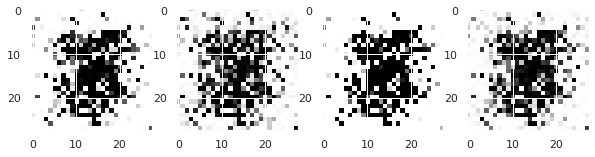

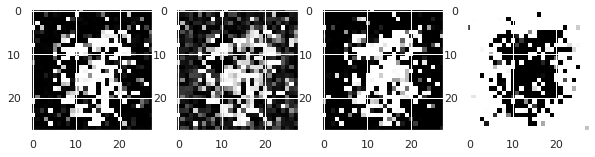

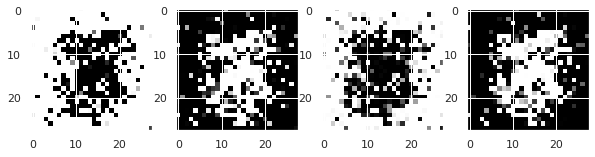

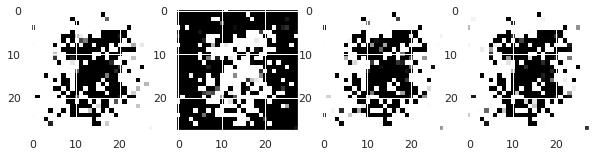

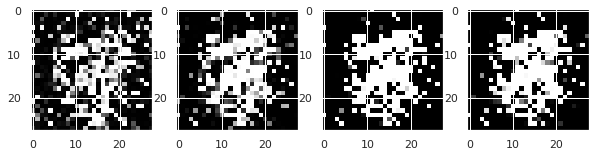

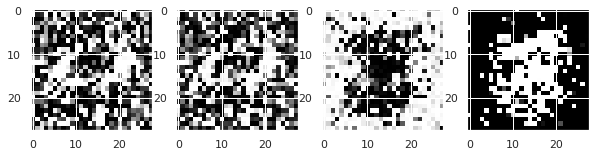

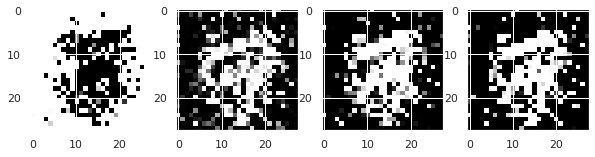

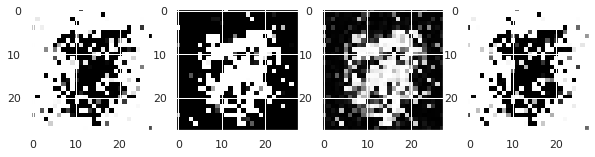

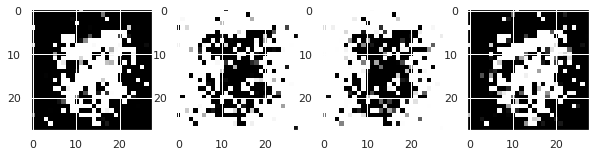

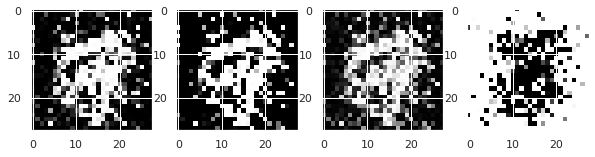

In [127]:
args["n_gen"]=6
args["lr"]=0.002
print(args)
trained_model = training_loop(args=args, verbose=False, warm_start=True, 
                              checkpoint_name='checkpoint_otgan_v9',plot_digit=True)

# Test the OT GAN 

- inception score ??
- v3 = same architecture and  hyperparameters as in the article
  - 8 epochs : Stop learning after 5 epochs approximatively .
  - last loss : 0.00115
- v4 : architecture found on medium, eps = 0.1. generator and discriminator perform equally after a certain number of epochs, loss even reached 0 : idea try to reduce the number ms to suof updates of the discriminator. Seems to suffer from the collapse mode...Even after 18 epochs it's not better.
- v5 : ngen = 6, very unstable . Also mode collapsing 
- v6 : beta1 = 0.5, negative loss at epoch 8 but after increased again 
- v7 same as v6 with lr = 0.0002. Afterb7 epochs loss started to increase...
- v8 : idea : go back to eps = 500? increase max_iter to 500?
- v9 : eps = 500, max_iter = 500, n_gen=6
- v10 : eps = 500, max_iter = 500, n_gen=2

- new architecture training more instable. But faster and it seems to generate digits. But always the same one ..

- IDEA for next architecture : don't use linear layer but convolutional and deconvolutional layers 

In [0]:
def plot_gen_images(checkpoint_path, generator, image_size=28, plot_history=False, n=4):
    '''
    plot images generated by a given model

    Parameters
    checkpoint_path : path where the model is saved
    generator : initial model
    image_size : either 28 or 32
    '''
    checkpoint = torch.load(checkpoint_path)
    try:
      args = checkpoint['args']
      print('args \n')
      for arg in list(args.keys()):
        print(arg, args[arg])
    except:
      pass

    generator.load_state_dict(checkpoint['model_state_dict'])
    with torch.no_grad():
      z = generator.generate_noise(n, 100)
      images = generator(z)
      images.size()
      images = images.reshape(n, 1, image_size,image_size)
      images.size()

      fig, ax = plt.subplots(1,n, figsize=(10, 5))
      for i in range(n):
        img = images[i]
        ax[i].imshow(img.numpy().squeeze(), cmap='gray')
      if plot_history:
        plt.figure(figsize=(10,5))
        plt.plot(checkpoint['loss_history'])
        plt.title('Loss evolution')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

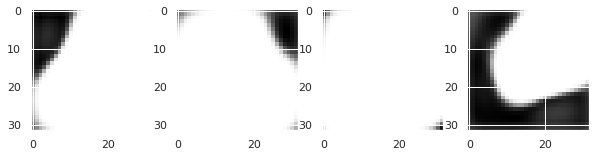

In [129]:
checkpoint_path = path + 'checkpoint_otgan_v3_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator32x32(), image_size=32)
#forgott the loss history at beginning

args 

batch_size 128
val_batch_size 128
n_epochs 20
lr 0.002
beta1 0.9
beta2 0.999
seed 1
cuda True
n_gen 3


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


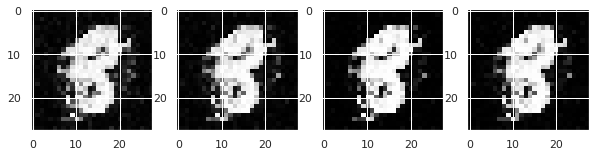

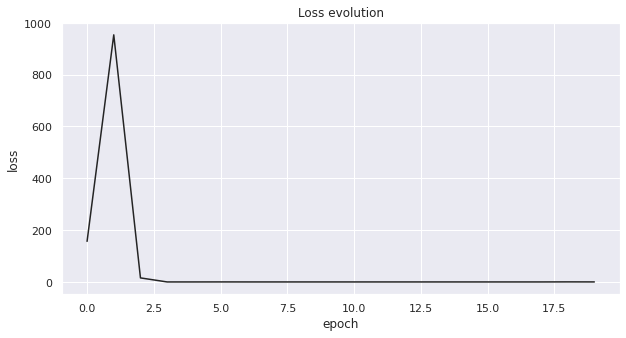

In [130]:
checkpoint_path = path + 'checkpoint_otgan_v4_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

In [0]:
checkpoint_path = path + 'checkpoint_otgan_v5_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 128
val_batch_size 128
n_epochs 10
lr 0.002
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


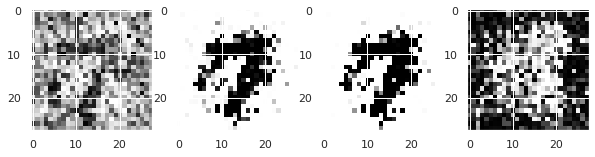

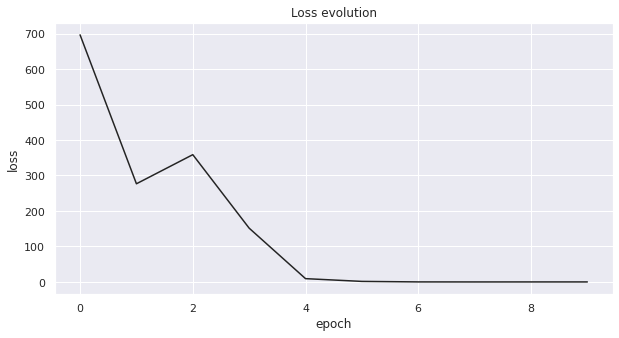

In [131]:
checkpoint_path = path + 'checkpoint_otgan_v6_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 128
val_batch_size 128
n_epochs 10
lr 0.0002
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


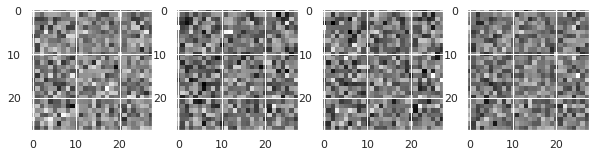

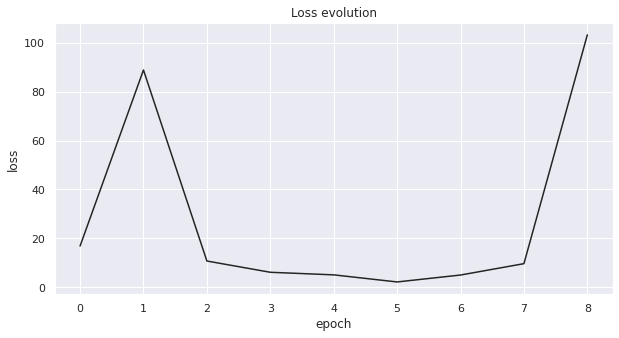

In [132]:
checkpoint_path = path + 'checkpoint_otgan_v7_generator.pt' #after 6 epochs
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

In [0]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

args 

batch_size 128
val_batch_size 128
n_epochs 10
lr 0.002
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


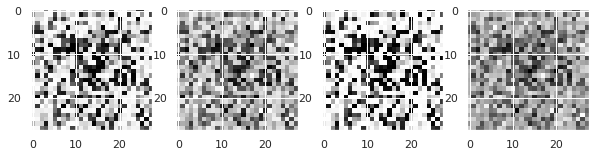

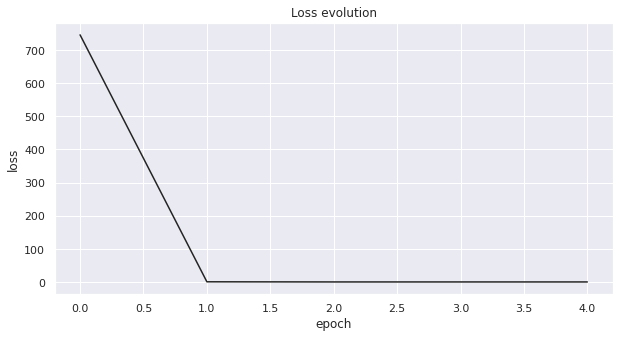

In [133]:
checkpoint_path = path + 'checkpoint_otgan_v8_generator.pt' #after 6 epochs
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 128
val_batch_size 128
n_epochs 10
lr 0.002
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


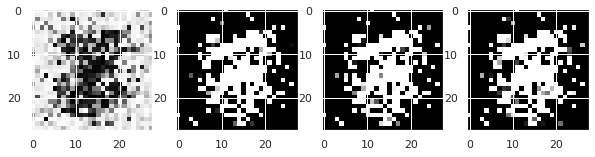

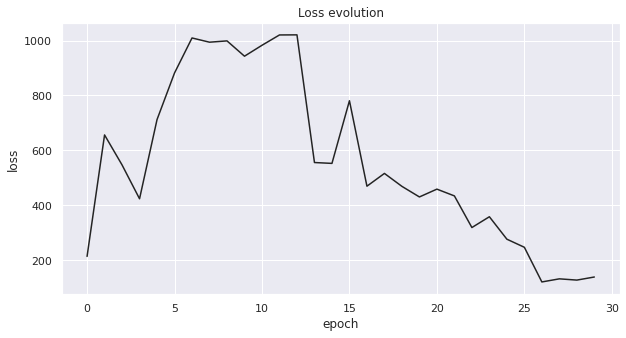

In [134]:
checkpoint_path = path + 'checkpoint_otgan_v9_generator.pt' #after 6 epochs
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 128
val_batch_size 128
n_epochs 10
lr 0.002
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


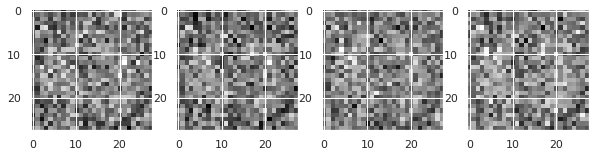

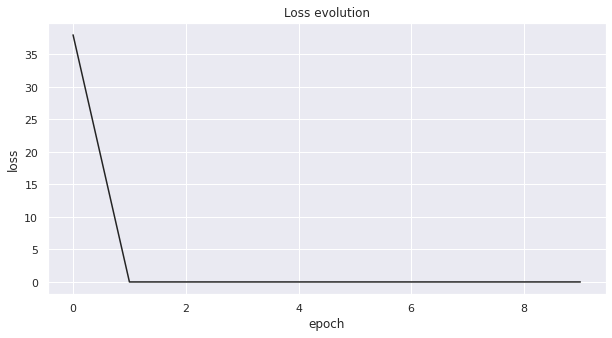

In [135]:
checkpoint_path = path + 'checkpoint_otgan_v10_generator.pt' #after 6 epochs
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 128
val_batch_size 128
n_epochs 10
lr 0.0002
beta1 0.5
beta2 0.999
seed 1
cuda True
n_gen 2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


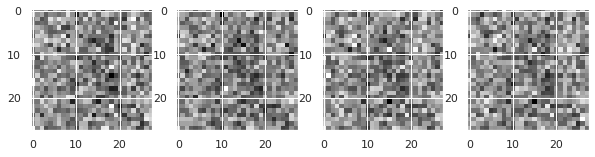

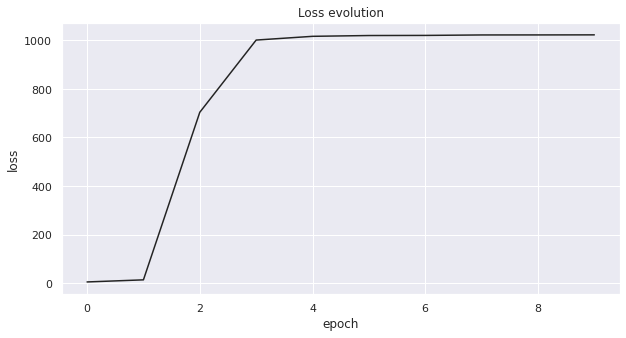

In [136]:
checkpoint_path = path + 'checkpoint_otgan_v11_generator.pt' #after 6 epochs
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

In [0]:

# class NoiseDB(VisionDataset):
#     '''Class with noise data'''
#     def __init__(self, dataset):
#         self.images = dataset
#         self.target = [0 for i in range(len(dataset))]
#         self.root = "add/pickle/location"
        
#         # Check length of target and image match
#         assert len(self.images) == len(self.target)
        
#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         target = self.target[index]
#         img = self.images[index]
            
#         return img, target

In [0]:
# class ConcatenateDB(VisionDataset):
#     '''Class to concatenate two dataset and return a tuple
#     Inputs : datasets to concatenate 
#     /!\ Assumptions :
#     - several datasets are provided
#     - both an image and a target are available (full of 0 if no target exists)
#     - the datasets are of same size 
#     Output : an iterable dataset, with a tuple of images and a tuple of targets provided at each iteration
#     '''
#     def __init__(self, *datasets):
#         nb_datasets = len(datasets)
#         len_datasets = len(datasets[0]) #assumes all datasets have the same length
#         all_images = [[DB[i][0] for i in range(len_datasets)] for DB in datasets]
#         all_targets = [[DB[i][1] for i in range(len_datasets)] for DB in datasets]
        
#         self.images = list(zip(*all_images))
#         self.targets = list(zip(*all_targets))
#         self.root = "add/pickle/location"
        
#         # Check length of target and image match
#         assert len(self.images) == len(self.targets)
        
#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         target = self.targets[index]
#         img = self.images[index]
            
#         return img, target

In [0]:
# # Trainset that concatenates the MNIST dataset and a dataset full of noise
# conc_trainset = ConcatenateDB(trainset_pad,Noise_trainset)
# # Data loader
# conc_loader = DataLoader(conc_trainset, args['batch_size'], shuffle=True, **kwargs)

In [0]:
# #philo


# all_loss_G = []
# all_loss_C = []
# all_synth_img = []
# all_features_real = []
# all_features_synth = []
    
# def train(model_C, model_G, loader, optimizer_C, optimizer_G, args, epoch, device = 'cpu'):
#     print('Training epoch {:d}'.format(epoch))
    
#     model_G.train() #?? ca fait quoi cette fonction
#     model_C.train()

#     # /!\/!\To uncomment (defined outside for now do to memory issues)
# #     all_loss_G = []
# #     all_loss_C = []
# #     all_synth_img = []
# #     all_features_real = []
# #     all_features_synth = []

#     for batch_idx, ((img, noise), (target, _)) in loader:
#         ## Sample two independent minibatches

#         # Sample a first minibatch
#         X = img.to(device)
#         Z = noise.detach().to(device)

#         # Take the next step of iterator to sample a second minibatch
#         batch_idx, ((imgp, noisep),(targetp, _p)) = next(loader)
#         Xp = imgp.to(device)
#         Zp = noisep.detach().to(device)

#         # Embed real images into feature space by applying critic
#         out_X = model_C(X).to(device) #added
#         out_Xp = model_C(Xp).to(device) #added
#         all_features_real.append((out_X,out_Xp))

#         # Generate synthesized image from noise
#         Y = model_G(Z)
#         Yp = model_G(Zp)
#         all_synth_img.append((Y,Yp))

#         # Embed synthesized images into the feature space by using the critic
#         # Question : remove gradient coming from the generator part ?? --> cf .detach()
#         out_Y = model_C(Y.detach()).to(device) #added
#         out_Yp = model_C(Yp.detach()).to(device) #added
#         all_features_synth.append((out_Y,out_Yp))

#         # Generator's update
#         loss_G = loss_cos_dist(out_X,out_Xp,out_Y,out_Yp, detach = False, device = device)
#         loss_G.backward(retain_graph=True) #?
#         optimizer_G.step()
#         optimizer_G.zero_grad()
#         all_loss_G.append(loss_G)

#         # Critic update (take into account the fact that we sample two minibatches at each round)
#         if batch_idx % (2*args["n_gen"]) == 0 :
#             loss_C = -loss_G
#             loss_C.backward()
#             optimizer_C.step()
#             optimizer_C.zero_grad()
#             all_loss_C.append(loss_C)
    
#     return {"loss_C": all_loss_C,
#            "loss_G": all_loss_G,
#            "all_synth_img": all_synth_img,
#            "all_features_synth" : all_features_synth,
#            "all_features_real" : all_features_real}

In [0]:
# ######### Initialize everything again
# # Load critic
# model_C = Critic32x32()
# model_C = model_C.to(device)
# optimizer_C = torch.optim.Adam(params = model_C.parameters(), lr=args["lr"], betas=(args["beta1"], args["beta2"]))

# # Load generator
# model_G = Generator32x32()
# model_G = model_G.to(device)
# optimizer_G = torch.optim.Adam(params = model_G.parameters(), lr=args["lr"], betas=(args["beta1"], args["beta2"]))

# # Check have an even number of minibatches
# assert len(conc_trainset) % 2 == 0

# ######### Define iterator
# conc_iterator = enumerate(conc_loader)


# ######## Test training
# train_result=[]
# for epoch in range(args["epochs"]):
#     train_result.append(train(model_C, model_G, conc_iterator, optimizer_C, optimizer_G, args, epoch, device = device))

Plot synthesized images after initialization of the generator network. 

**TODO** : check if padding is a problem when training the model --> look at the border of synthesized images

In [0]:
# ##### First epoch
# # all_synth_img = train_result[0]["all_synth_img"]

# fig, ax = plt.subplots(1,4, figsize=(15,7))
# # First iteration (only take the first image of each minibatch)
# ax[0].imshow(all_synth_img[0][0][0][0].detach(), cmap=plt.cm.gray)
# ax[1].imshow(all_synth_img[0][1][0][0].detach(), cmap=plt.cm.gray)
# # Second iteration
# ax[2].imshow(all_synth_img[1][0][0][0].detach(), cmap=plt.cm.gray)
# ax[3].imshow(all_synth_img[1][1][0][0].detach(), cmap=plt.cm.gray)
# plt.suptitle("Plot generated images after two iterations")
# plt.subplots_adjust(top=1.2)
# plt.show()